#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns

In [2]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [4]:
from data_loader import makeTensorLoaders

In [5]:
import copy

#### Test for CUDA

In [6]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Simulation parameters

In [7]:
N = 128 ## number of recurrent neurons
nsecs = 500 ## time (originally 1440)
dt = 0.2 ## bin size

In [8]:
nRuns = 5

In [9]:
simtime_len = int(nsecs/dt)

simtime_train = np.arange(0, nsecs, dt)
simtime_test = np.arange(1 * nsecs, 2 * nsecs, dt)

In [10]:
amp = 1.5
freq = 1/50

In [11]:
ft_train_exc = {}
ft_train_inh = {}

In [12]:
scale1 = {}
scale2 = {}
scale3 = {}
scale4 = {}
phi = {}

In [13]:
for cntr in range(nRuns):
    scale1[cntr] = np.random.randint(1,6)
    scale2[cntr] = np.random.randint(1,6)
    scale3[cntr] = np.random.randint(1,6)
    scale4[cntr] = np.random.randint(1,6)
    
    phi[cntr] = -1*np.random.randint(4,7)*np.pi/6
    
    ft_train_exc[cntr] = (amp/1.0) * np.sin(scale1[cntr] *np.pi*freq*simtime_train) 
    + (amp/3.0)*np.sin(scale2[cntr] *np.pi* freq*simtime_train)
    
    ft_train_inh[cntr] = (amp/2.0) * np.sin(scale3[cntr] *np.pi*freq*simtime_train + phi[cntr]) 
    + (amp/0.8)*np.sin(scale4[cntr] *np.pi* freq*simtime_train + phi[cntr])

In [14]:
kk = 2
print(scale1[kk])
print(scale2[kk])

3
2


Text(0.5, 1.0, 'Waveforms')

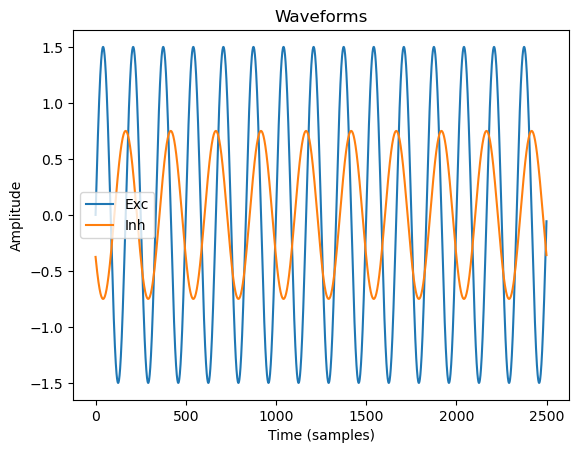

In [15]:
plt.plot(ft_train_exc[kk], label='Exc')
plt.plot(ft_train_inh[kk], label= 'Inh')
plt.legend()
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Waveforms')

(-1.6, 1.6)

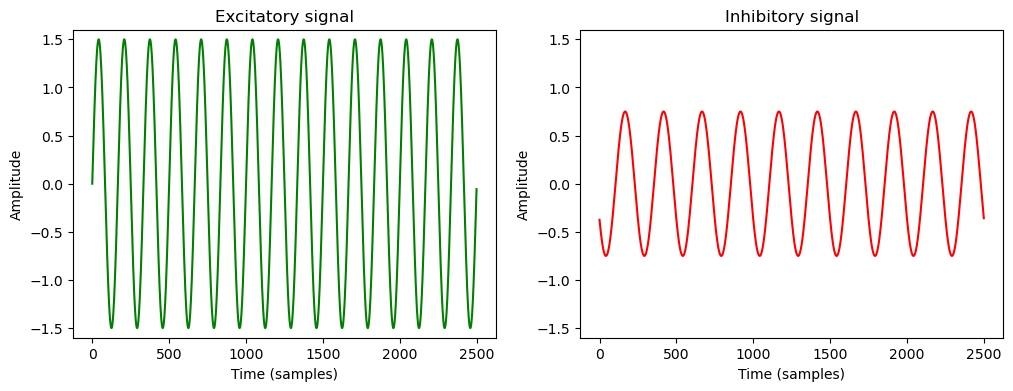

In [16]:
fwaves = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(ft_train_exc[kk], color='g')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Excitatory signal')
plt.ylim(-1.6,1.6)

plt.subplot(122)
plt.plot(ft_train_inh[kk], color='r')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Inhibitory signal')
plt.ylim(-1.6,1.6)

#### Train and test datasets

In [17]:
def divide_into_chunks(array, k, n):
    N = len(array)
    start_indices = np.random.randint(0, N - n, size=k)  # Generate k random starting indices
    chunks0 = [array[start_idx:start_idx + n] for start_idx in start_indices]
    chunks1 = [array[start_idx + 1:start_idx + 1 + n] for start_idx in start_indices]
    return np.stack(chunks0), np.stack(chunks1)

In [18]:
batch_size = 100
nSamps_train = 1000
nSamps_test = 1000
lenSeq = 500

In [19]:
data_train_exc = {}
data_train_inh = {}

data_test_exc = {}
data_test_inh = {}

target_train_exc = {}
target_test_exc = {}

target_train_inh = {}
target_test_inh = {}

data_train = {}
data_test = {}

target_train = {}
target_test = {}

In [20]:
train_loader = {}
test_loader = {}

In [21]:
for cntr in range(nRuns):
    data_train_exc[cntr], target_train_exc[cntr] = divide_into_chunks(ft_train_exc[cntr], nSamps_train, lenSeq)
    data_test_exc[cntr], target_test_exc[cntr] = divide_into_chunks(ft_train_exc[cntr], nSamps_test, lenSeq)
    
    data_train_inh[cntr], target_train_inh[cntr] = divide_into_chunks(ft_train_inh[cntr], nSamps_train, lenSeq)
    data_test_inh[cntr], target_test_inh[cntr] = divide_into_chunks(ft_train_inh[cntr], nSamps_test, lenSeq)
    
    data_train[cntr] = np.hstack((np.expand_dims(data_train_exc[cntr],1), np.expand_dims(data_train_inh[cntr],1)))
    data_test[cntr] = np.hstack((np.expand_dims(data_test_exc[cntr],1), np.expand_dims(data_test_inh[cntr],1)))
    
    target_train[cntr] = np.hstack((np.expand_dims(target_train_exc[cntr],1),np.expand_dims(target_train_inh[cntr],1)))
    target_test[cntr] = np.hstack((np.expand_dims(target_test_exc[cntr],1),np.expand_dims(target_test_inh[cntr],1)))
    
    train_loader[cntr] = makeTensorLoaders((data_train[cntr], target_train[cntr]), batch_size, shuffle=True)
    test_loader[cntr] = makeTensorLoaders((data_test[cntr], target_test[cntr]), batch_size, shuffle=True)

#### Model and other hyper-params

In [22]:
num_layers = 1
input_size = 2
hidden_size = N
output_size = 1

In [23]:
def initialize_weights(N, index_ranges, signs):
    weights = np.zeros((N, N))
    for ii, (start, end) in enumerate(index_ranges):
        limit = 1 / np.sqrt(N) if signs[ii] == 1 else -1/np.sqrt(N)
        weights[:, start:end] = np.random.uniform(0, limit, size=(N, end-start))
    return weights

In [24]:
def generate_mask(weights, index_ranges, signs):
    mask = np.zeros_like(weights)
    for i, (start, end) in enumerate(index_ranges):
        if signs[i] == 1:
            mask[:, start:end] = np.where(weights[:, start:end] > 0, 1, 0)
        elif signs[i] == -1:
            mask[:, start:end] = np.where(weights[:, start:end] < 0, 1, 0)
    return mask

In [25]:
frac_ex = 0.8
frac_in = 1-frac_ex

In [26]:
start_ex = 0
end_ex = round(N*frac_ex)
start_in = round(N*frac_ex)
end_in = N

In [27]:
signs = [1,-1]
index_ranges = [(0,int(N*frac_ex)),(int(N*frac_ex),N)]

In [28]:
# Define the neural network
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, frac_list, num_classes, device):
        
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(round(hidden_size*frac_list[0]), num_classes)
        self.fc2 = nn.Linear(round(hidden_size*frac_list[1]), num_classes)
        self.n_classes = num_classes
        self.device = device
        self.fracs = frac_list

    def forward(self, x):
        ## Define input mask
        in_mask = torch.zeros(self.hidden_size, self.input_size).to(device)
        in_mask[start_ex:end_ex,0] = 1.
        in_mask[start_in:end_in,1] = 1.        
        
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, inDim, nSteps = x.shape
        
        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)
        pred1 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred2 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        
        for ii in range(nSteps):
            ## Apply input mask
            self.rnn.weight_ih_l0.data.mul(in_mask)
        
            ip = torch.unsqueeze(x[:,:,ii],-1).view(nSamp,1,inDim)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
            fr_mask = ht.clone()>0
            htt = fr_mask*ht.clone() ## mask firing rate
            h0 = htt ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred1[:,ii,:] = self.fc1(ops[:, ii, :round(self.hidden_size*self.fracs[0])].clone())
            pred2[:,ii,:] = self.fc2(ops[:, ii, round(self.hidden_size*self.fracs[0]):].clone())
            
        out1 = pred1.clone() #Take the output from the last time step
        out2 = pred2.clone() #Take the output from the last time step
        
        return torch.vstack((out1,out2)), htt

In [29]:
# Initialize the model
model = {}
weights_init = {}

In [30]:
for cntr in range(nRuns):
    model[cntr] = SimpleRNN(input_size, hidden_size, [frac_ex, frac_in], output_size, device).to(device)
    weights_init[cntr] = initialize_weights(N,index_ranges,signs)
    model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(weights_init[cntr]).float().to(device)

Text(0.5, 1.0, 'Initial Weights: Dales Backprop')

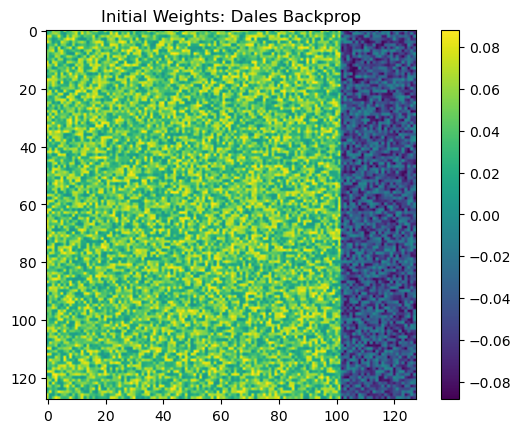

In [31]:
kk = 0

plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights: Dales Backprop')

#### Model training

In [32]:
num_epochs = 25
learning_rate = 0.001

In [33]:
criterion = nn.MSELoss()

optimizer = {}
for cntr in range(nRuns):
    optimizer[cntr] = optim.Adam(model[cntr].parameters(), lr=learning_rate)

In [34]:
train_losses = np.zeros((nRuns, num_epochs))
test_losses = np.zeros((nRuns, num_epochs))

In [35]:
for run in tqdm(range(nRuns)):
    model[run].train()
    train_loss_min = np.Inf
    for epoch in range(1, num_epochs+1):
        print('Epoch: ',epoch)

        train_loss = 0.0
        test_loss = 0.0
        
        for inputs, targets in train_loader[run]:
            if train_on_gpu:
                inputs, targets = inputs.float().cuda(), torch.unsqueeze(targets.float().cuda(),-1)
                targets_f = torch.vstack((torch.squeeze(targets)[:,0,:],torch.squeeze(targets)[:,1,:]))
                model[run].cuda()
            else:
                inputs, targets = inputs.float(), torch.unsqueeze(targets.float(),-1)
                targets_f = torch.vstack((torch.squeeze(targets)[:,0,:],torch.squeeze(targets)[:,1,:]))

            optimizer[run].zero_grad()
            outputs, firing_rates = model[run](inputs)
            outputs = torch.squeeze(outputs)
            if train_on_gpu:
                outputs = outputs.cuda()
            loss = criterion(outputs, targets_f)
            train_loss += loss.item()

            loss.backward()
            optimizer[run].step()

            ## Dale's backprop
            w = model[run].rnn.weight_hh_l0.detach().cpu().numpy()
            mask = generate_mask(w, index_ranges, signs)
            wm = w*mask
            model[run].rnn.weight_hh_l0.data = torch.from_numpy(wm).float().cuda()

        if train_loss< train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            train_loss_min = train_loss
        
        train_losses[run][epoch-1] = train_loss
            
        for inputs_test, targets_test in test_loader[run]:
            if train_on_gpu:
                inputs_test, targets_test = inputs_test.float().cuda(), torch.unsqueeze(targets_test.float().cuda(),-1)
                targets_f_test = torch.vstack((torch.squeeze(targets_test)[:,0,:],torch.squeeze(targets_test)[:,1,:]))
                model[run].cuda()
            else:
                inputs_test, targets_test = inputs_test.float(), torch.unsqueeze(targets_test.float(),-1)
                targets_f_test = torch.vstack((torch.squeeze(targets_test)[:,0,:],torch.squeeze(targets_test)[:,1,:]))
                
            outputs_test, firing_rates_test = model[run](inputs_test)
            outputs_test = torch.squeeze(outputs_test)
            if train_on_gpu:
                outputs_test = outputs_test.cuda()
            loss_test = criterion(outputs_test, targets_f_test)
            test_loss += loss_test.item()
            
        test_losses[run][epoch-1] = test_loss

        print('Epoch: {}, Test Loss({:.6f})'.format(epoch,test_loss))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->8.464899)
Epoch: 1, Test Loss(7.077379)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (8.464899-->7.260158)
Epoch: 2, Test Loss(7.129394)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (7.260158-->6.974581)
Epoch: 3, Test Loss(6.843973)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (6.974581-->6.582528)
Epoch: 4, Test Loss(6.193215)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (6.582528-->5.459795)
Epoch: 5, Test Loss(4.469014)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (5.459795-->3.245023)
Epoch: 6, Test Loss(2.116230)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (3.245023-->1.340123)
Epoch: 7, Test Loss(0.623423)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (1.340123-->0.522633)
Epoch: 8, Test Loss(0.324491)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (0.522633-->0.219151)
Epoch: 9, Test Loss(0.134962)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (0.219151-->0.103236)
Epoch: 10, Test Loss(0.078856)
Epoch:  11
Epoch: 11, Train Loss Decreased!! (0.1032

 20%|██        | 1/5 [09:11<36:46, 551.59s/it]

Epoch: 25, Test Loss(0.021170)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->7.013026)
Epoch: 1, Test Loss(6.938813)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (7.013026-->6.628837)
Epoch: 2, Test Loss(5.526598)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (6.628837-->4.666068)
Epoch: 3, Test Loss(3.240222)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (4.666068-->2.269595)
Epoch: 4, Test Loss(1.499282)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (2.269595-->1.097611)
Epoch: 5, Test Loss(0.733812)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (1.097611-->0.573016)
Epoch: 6, Test Loss(0.360481)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (0.573016-->0.195165)
Epoch: 7, Test Loss(0.088605)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (0.195165-->0.092686)
Epoch: 8, Test Loss(0.079994)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (0.092686-->0.064958)
Epoch: 9, Test Loss(0.059115)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (0.064958-->0.054847)
Epoch: 10, Test Loss(0.047919)
Epoch:  11
Epoch: 11,

 40%|████      | 2/5 [18:33<27:52, 557.57s/it]

Epoch: 25, Test Loss(0.023105)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->7.017970)
Epoch: 1, Test Loss(6.926895)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (7.017970-->6.499754)
Epoch: 2, Test Loss(4.871433)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (6.499754-->3.583950)
Epoch: 3, Test Loss(2.406255)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (3.583950-->1.988718)
Epoch: 4, Test Loss(1.509039)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (1.988718-->1.254604)
Epoch: 5, Test Loss(1.014041)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (1.254604-->0.889176)
Epoch: 6, Test Loss(0.727866)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (0.889176-->0.581529)
Epoch: 7, Test Loss(0.410859)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (0.581529-->0.285064)
Epoch: 8, Test Loss(0.159036)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (0.285064-->0.120944)
Epoch: 9, Test Loss(0.099992)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (0.120944-->0.086654)
Epoch: 10, Test Loss(0.064741)
Epoch:  11
Epoch: 11,

 60%|██████    | 3/5 [27:52<18:36, 558.41s/it]

Epoch: 25, Test Loss(0.023139)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->7.297208)
Epoch: 1, Test Loss(7.160612)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (7.297208-->6.989541)
Epoch: 2, Test Loss(6.744381)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (6.989541-->6.036891)
Epoch: 3, Test Loss(4.832594)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (6.036891-->4.288251)
Epoch: 4, Test Loss(3.505613)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (4.288251-->2.498992)
Epoch: 5, Test Loss(1.487657)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (2.498992-->1.086190)
Epoch: 6, Test Loss(0.691305)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (1.086190-->0.564613)
Epoch: 7, Test Loss(0.418057)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (0.564613-->0.286458)
Epoch: 8, Test Loss(0.172729)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (0.286458-->0.143390)
Epoch: 9, Test Loss(0.105492)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (0.143390-->0.092554)
Epoch: 10, Test Loss(0.078026)
Epoch:  11
Epoch: 11,

 80%|████████  | 4/5 [37:16<09:20, 560.44s/it]

Epoch: 25, Test Loss(0.024489)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->7.132438)
Epoch: 1, Test Loss(7.020562)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (7.132438-->6.948354)
Epoch: 2, Test Loss(6.746544)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (6.948354-->6.146425)
Epoch: 3, Test Loss(5.030019)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (6.146425-->3.969914)
Epoch: 4, Test Loss(2.554325)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (3.969914-->2.053982)
Epoch: 5, Test Loss(1.638298)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (2.053982-->1.496160)
Epoch: 6, Test Loss(1.343980)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (1.496160-->1.237284)
Epoch: 7, Test Loss(1.112918)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (1.237284-->0.993258)
Epoch: 8, Test Loss(0.849068)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (0.993258-->0.709178)
Epoch: 9, Test Loss(0.543070)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (0.709178-->0.391194)
Epoch: 10, Test Loss(0.215438)
Epoch:  11
Epoch: 11,

100%|██████████| 5/5 [46:41<00:00, 560.32s/it]

Epoch: 25, Test Loss(0.037496)


In [36]:
outputs_test_np = outputs_test.detach().cpu().numpy()
targets_test_np = targets_test.detach().cpu().numpy()
firing_rates_test_np = firing_rates_test.detach().cpu().numpy()

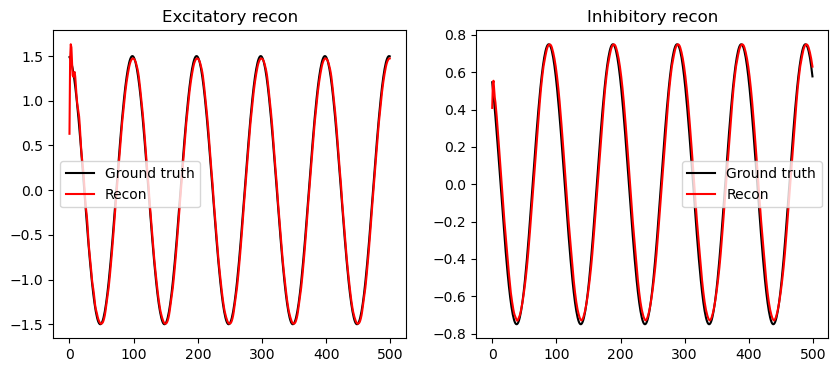

In [37]:
kk = 18

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(targets_test_np[kk,0],label='Ground truth',color='k')
plt.plot(outputs_test_np[kk],label='Recon',color='r')
plt.title('Excitatory recon')
plt.legend()

plt.subplot(122)
plt.plot(targets_test_np[kk,1],label='Ground truth',color='k')
plt.plot(outputs_test_np[batch_size+kk],label='Recon',color='r')
plt.title('Inhibitory recon')
plt.legend()

In [38]:
weights_final = {}
for cntr in range(nRuns):
    weights_final[cntr] = model[cntr].rnn.weight_hh_l0.detach().cpu().numpy()

In [39]:
mean_train_losses = np.mean(train_losses, axis=0)
variance_train_losses = np.var(train_losses, axis=0)

mean_test_losses = np.mean(test_losses, axis=0)
variance_test_losses = np.var(test_losses, axis=0)

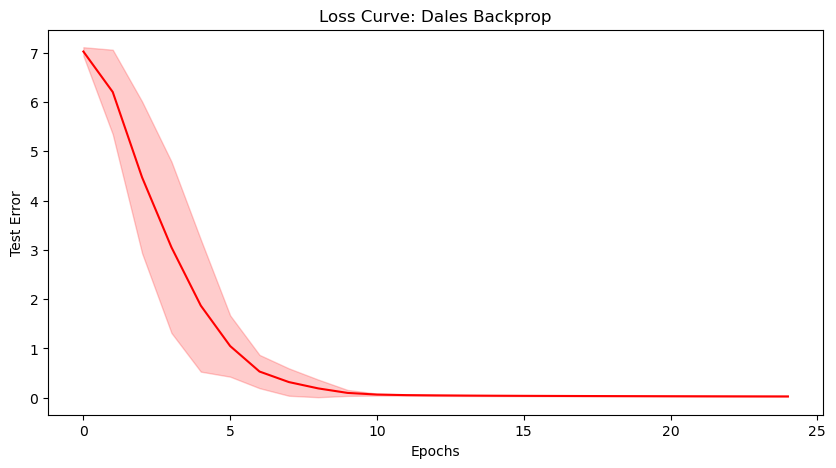

In [40]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
# sns.lineplot(x=x, y=mean_train_losses, color='r')
# plt.fill_between(x, mean_train_losses - np.sqrt(variance_train_losses), mean_train_losses + np.sqrt(variance_train_losses),
#                  color='r', alpha=0.2)

sns.lineplot(x=x, y=mean_test_losses, color='r')
plt.fill_between(x, mean_test_losses - np.sqrt(variance_test_losses), mean_test_losses + np.sqrt(variance_test_losses),
                 color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Error')
plt.title('Loss Curve: Dales Backprop')

# Show plot
plt.show()

## Pruning

#### Define functions

In [41]:
def random_prune(A, p):
    
    A += 1e-25
    
    # Ensure p is in the range [0, 1]
    p = max(0, min(1, p))
    # Adjust p based on the sparsity of the original matrix
    p_adjusted = -1.0 + np.sum(A!=0)/np.prod(A.shape) + p
    # Determine the threshold for setting elements to zero
    threshold = 1.0 - p_adjusted
    # Generate a random mask for sparsification
    mask = np.random.random(A.shape)
    # Set mask = 1 where A is already 0 and random elsewhere
    mask = np.where(A==0, 1, mask)
    # Apply the mask to the matrix to sparsify it
    sparsified_matrix = np.where(mask > threshold, A, 0)
    return sparsified_matrix

In [42]:
def distribute_equally(arr):
    
    r = np.sum(np.where(arr>1, arr-1, 0))
    
    while r>0:
        # Count number of probs less than 1
        count_less_than_one = sum(1 for num in arr if num < 1)
        # Estimate delta to be added per number
        delta = 0
        if count_less_than_one > 0:
            delta = r/count_less_than_one
        # return new array with delta added appropriately
        arr = np.where(arr<1, arr+delta, 1)
        # calculate new residue
        r = np.sum(np.where(arr>1, arr-1, 0))
    
    return arr

In [43]:
def topprob_prune(A, s):
    
    #A += 1e-25
    
    N_post = A.shape[0]
    N_pre = A.shape[1]
    A_sparse = np.zeros_like(A)
    
    z0 = np.sum(A==0) + np.min((N_pre,N_post))
    if z0 > 0:
        z = s*np.prod(A.shape)
        s = (z-z0)/(np.prod(A.shape)-z0)
    
    if N_post == N_pre:
        D = -1*np.diag(np.diag(A))
        W = A #+ D
    else:
        d_vals = -1*np.diag(A)
        D = np.zeros_like(A)
        np.fill_diagonal(D, d_vals)
        W = A #+ D
    
    K = N_pre*N_post*(1-s)/np.sum(np.abs(W))
    Pmat = np.zeros_like(W)
    
    for ii in range(N_post):
        for jj in range(N_pre):
            
            if np.abs(W[ii,jj])>0:
                Pij = K*(np.abs(W[ii,jj]))
                Pmat[ii,jj] = Pij
    
    Pmat_adjusted = distribute_equally(Pmat.ravel())
    Pmat_adjusted = Pmat_adjusted.reshape(N_post, N_pre)
                
    for ii in range(N_post):
        for jj in range(N_pre):
            if np.abs(W[ii,jj])>0:
                Pij = Pmat_adjusted[ii,jj]    
                if np.random.uniform() < Pij:
                    A_sparse[ii,jj] = A[ii,jj]
    
    return A_sparse, K

#### Trials

In [44]:
rr = 0
prob_trial = 0.
s_trial = 1 - prob_trial

In [45]:
A_trial = weights_final[rr]

# trial with random pruning
A_trial_random = random_prune(A_trial,prob_trial)

## trial with topprob pruning
A_trial_topprob, _ = topprob_prune(A_trial,s_trial)

In [46]:
print(np.sum(A_trial_random==0)/N**2)
print(np.sum(A_trial_topprob==0)/N**2)

1.0
1.0


#### Prune using final weights

In [47]:
prob_list = np.linspace(1e-2, 1, 14)
prob_list = np.hstack((np.zeros(1),prob_list))
s_list = 1-prob_list

In [48]:
print('Conn probs = ', prob_list)
print('--------------------------------')
print('--------------------------------')
print('Sparisties = ', s_list)

Conn probs =  [0.         0.01       0.08615385 0.16230769 0.23846154 0.31461538
 0.39076923 0.46692308 0.54307692 0.61923077 0.69538462 0.77153846
 0.84769231 0.92384615 1.        ]
--------------------------------
--------------------------------
Sparisties =  [1.         0.99       0.91384615 0.83769231 0.76153846 0.68538462
 0.60923077 0.53307692 0.45692308 0.38076923 0.30461538 0.22846154
 0.15230769 0.07615385 0.        ]


In [49]:
n = len(prob_list)

sparsities_list_random = np.zeros((nRuns,n))
sparsities_list_topprob = np.zeros((nRuns,n))

A_pruned_list_random = np.zeros((nRuns,n,N,N))
A_pruned_list_topprob = np.zeros((nRuns,n,N,N))

errors_list_random = np.zeros((nRuns,n))
errors_list_topprob = np.zeros((nRuns,n))

In [50]:
# Initialize the model
mp_random = {}
mp_topprob = {}

In [51]:
for run in tqdm(range(nRuns)):
    A = weights_final[run]
    
    mp_random[run] = copy.deepcopy(model[run])
    mp_topprob[run] = copy.deepcopy(model[run])
    
    for ii, pp in enumerate(prob_list):
        ss = s_list[ii]
        A_pruned_list_random[run,ii] = random_prune(A,pp)
        A_pruned_list_topprob[run,ii], _ = topprob_prune(A,ss)
        
        sparsities_list_random[run,ii] = np.sum(A_pruned_list_random[run,ii]==0)/N**2
        sparsities_list_topprob[run,ii] = np.sum(A_pruned_list_topprob[run,ii]==0)/N**2
        
        mp_random[run].rnn.weight_hh_l0.data = mp_random[run].rnn.weight_hh_l0.data.copy_(torch.from_numpy(A_pruned_list_random[run,ii]).cuda())
        op_random, frp = mp_random[run](inputs)
        op_random = torch.squeeze(op_random)
        errors_list_random[run,ii] = criterion(op_random.cuda(), targets_f)
        
        mp_topprob[run].rnn.weight_hh_l0.data = mp_topprob[run].rnn.weight_hh_l0.data.copy_(torch.from_numpy(A_pruned_list_topprob[run,ii]).cuda())
        op_topprob, frp = mp_topprob[run](inputs)
        op_topprob = torch.squeeze(op_topprob)
        errors_list_topprob[run,ii] = criterion(op_topprob.cuda(), targets_f)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\abalwani6\AppData\Local\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:509: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,
100%|██████████| 5/5 [01:43<00:00, 20.71s/it]


In [52]:
xtick_labels = [str(np.round(k,3)) for k in prob_list]
xtick_positions = np.arange(len(prob_list))

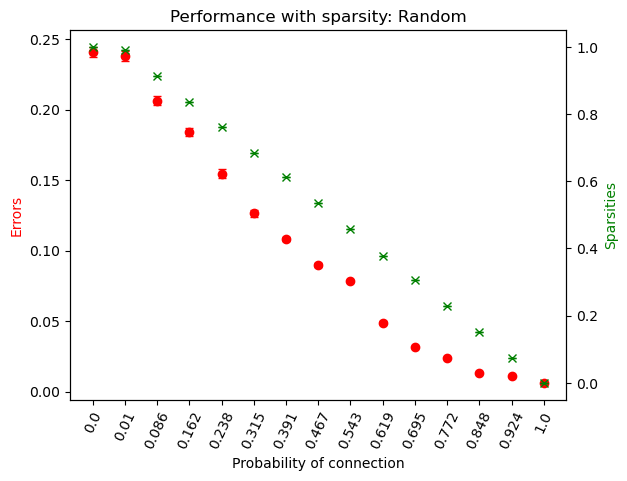

In [53]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot the first dataset using the first axis
ax.errorbar(np.arange(len(prob_list)), np.mean(errors_list_random,0), yerr=np.var(errors_list_random,0), fmt='o', capsize=3, color='r')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)
ax.set_ylabel('Errors', color='r')

# Create a second axis sharing the same x-axis
ax2 = ax.twinx()
ax2.errorbar(np.arange(len(prob_list)), np.mean(sparsities_list_random,0), yerr=np.var(sparsities_list_random,0), fmt='x', capsize=3, color='g')
ax2.set_ylabel('Sparsities', color='g')


ax.set_title('Performance with sparsity: Random')
ax.set_xlabel('Probability of connection')
plt.show()

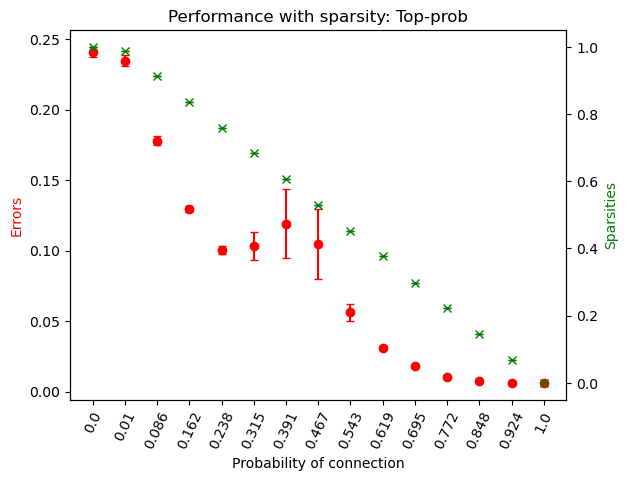

In [54]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Plot the first dataset using the first axis
ax.errorbar(np.arange(len(s_list)), np.mean(errors_list_topprob,0), yerr=np.var(errors_list_topprob,0), fmt='o', capsize=3, color='r')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)
ax.set_ylabel('Errors', color='r')

# Create a second axis sharing the same x-axis
ax2 = ax.twinx()
ax2.errorbar(np.arange(len(s_list)), np.mean(sparsities_list_topprob,0), yerr=np.var(sparsities_list_topprob,0), fmt='x', capsize=3, color='g')
ax2.set_ylabel('Sparsities', color='g')


ax.set_title('Performance with sparsity: Top-prob')
ax.set_xlabel('Probability of connection')
plt.show()

Text(0.5, 1.0, 'Sparsity vs. Probability of connection')

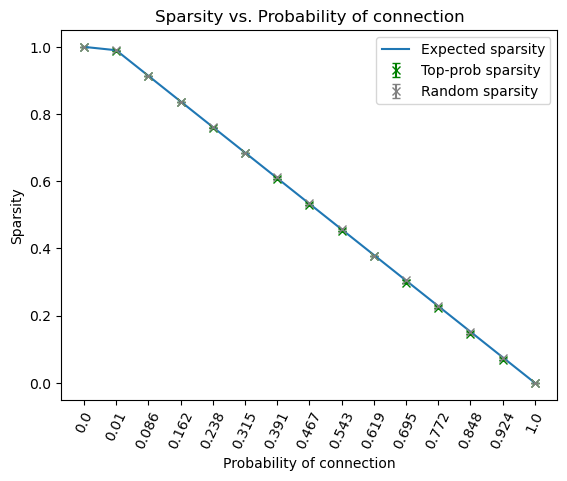

In [55]:
fig, ax = plt.subplots()

plt.errorbar(np.arange(len(s_list)), np.mean(sparsities_list_topprob,0), yerr=np.var(sparsities_list_topprob,0),
             fmt='x', capsize=3, color='g', label='Top-prob sparsity')
plt.errorbar(np.arange(len(prob_list)), np.mean(sparsities_list_random,0), yerr=np.var(sparsities_list_random,0),
             fmt='x', capsize=3, color='grey', label='Random sparsity')
plt.plot(np.arange(len(prob_list)), s_list, label = 'Expected sparsity')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)

plt.legend()
plt.ylabel('Sparsity')
plt.xlabel('Probability of connection')
plt.title('Sparsity vs. Probability of connection')

Text(0.5, 0, 'Connection probabilities')

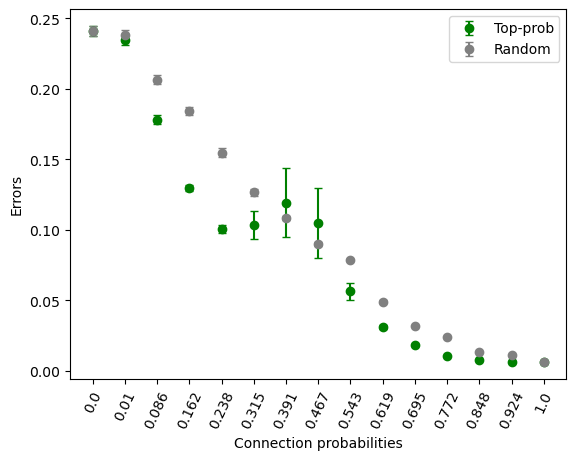

In [56]:
fig, ax = plt.subplots()

plt.errorbar(np.arange(len(s_list)), np.mean(errors_list_topprob,0), yerr=np.var(errors_list_topprob,0),
             fmt='o', capsize=3, color='g', label='Top-prob')
plt.errorbar(np.arange(len(prob_list)), np.mean(errors_list_random,0), yerr=np.var(errors_list_random,0),
             fmt='o', capsize=3, color='grey', label='Random')
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels,rotation=65)

plt.legend()
plt.ylabel('Errors')
plt.xlabel('Connection probabilities')

In [57]:
# np.save('errors_list_random_wave_recon.npy',errors_list_random)
# np.save('errors_list_topprob_wave_recon.npy',errors_list_topprob)

In [58]:
means = [np.mean(errors_list_topprob), np.mean(errors_list_random)]
devs = [np.var(errors_list_topprob), np.var(errors_list_random)]

In [59]:
labels = ['Top-prob','Random']
x_pos = np.arange(len(labels))

colours = ['g','grey']

Text(0.5, 1.0, 'Wave Recon: Error with pruned model')

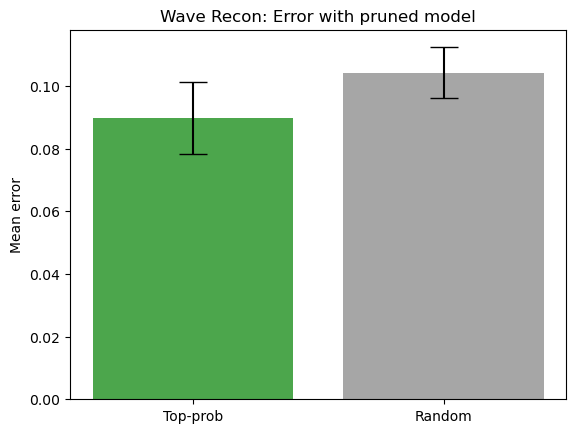

In [60]:
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=devs, align='center', alpha=0.7, ecolor='black', capsize=10, color=colours)

# Add labels and title
ax.set_ylabel('Mean error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Wave Recon: Error with pruned model')

#### Retraining: random training v/s topprob training

In [76]:
min_losses = {}
for cntr in range(nRuns):
    min_losses[cntr] = test_losses[cntr][-1]
avg_min = sum(min_losses.values())/nRuns

In [62]:
min_losses

{0: 0.02116958051919937,
 1: 0.023105272790417075,
 2: 0.02313879714347422,
 3: 0.02448862395249307,
 4: 0.03749619098380208}

In [80]:
n_fine = 10

In [63]:
def retrain(mp, pruned_rnn_weights, train_loss_min, loader, num_epochs_finetune=n_fine):
    
    rnn_mask = torch.from_numpy((pruned_rnn_weights!=0).astype(int)).cuda()
    
    mp.rnn.weight_hh_l0.data = mp.rnn.weight_hh_l0.data.copy_(torch.from_numpy(pruned_rnn_weights).cuda())
    finetune_optimizer = optim.Adam(mp.parameters(), lr=learning_rate)
    
    train_losses = np.zeros((num_epochs_finetune))
    
    mp.train()
    for epoch in (range(1, num_epochs_finetune+1)):
        #print(epoch)
    
        train_loss = 0.0
        for inputs, targets in loader:
            if train_on_gpu:
                inputs, targets = inputs.float().cuda(), torch.unsqueeze(targets.float().cuda(),-1)
                targets_f = torch.vstack((torch.squeeze(targets)[:,0,:],torch.squeeze(targets)[:,1,:]))
                mp.cuda()
            else:
                inputs, targets = inputs.float(), torch.unsqueeze(targets.float(),-1)
                targets_f = torch.vstack((torch.squeeze(targets)[:,0,:],torch.squeeze(targets)[:,1,:]))

            finetune_optimizer.zero_grad()
            oops, frps = mp(inputs)
            oops = torch.squeeze(oops)
            if train_on_gpu:
                oops = oops.cuda()
            loss = criterion(oops, targets_f)
            loss.backward()
            finetune_optimizer.step()
            train_loss += loss.item()

            ## Dale's backprop
            w = mp.rnn.weight_hh_l0.detach().cpu().numpy()
            mask = generate_mask(w, index_ranges, signs)
            wm = w*mask
            mp.rnn.weight_hh_l0.data = torch.from_numpy(wm).float().cuda()

            ## make sure sparsity mask is applied
            mp.rnn.weight_hh_l0.data = rnn_mask*mp.rnn.weight_hh_l0.data

        if train_loss< train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            train_loss_min = train_loss
        
        train_losses[epoch-1] = train_loss
        #print(train_loss)
            
    return mp, train_losses

In [64]:
model_finetuned_random = {}
model_finetuned_topprob = {}

train_losses_finetuned_random = {}
train_losses_finetuned_topprob = {}

In [65]:
## retrain from ~90% sparse 

for run in tqdm(range(nRuns)):
    model_finetuned_random[run], train_losses_finetuned_random[run] = retrain(copy.deepcopy(model[run]), A_pruned_list_random[run][2], min_losses[run], train_loader[run])
    model_finetuned_topprob[run], train_losses_finetuned_topprob[run] = retrain(copy.deepcopy(model[run]), A_pruned_list_topprob[run][2], min_losses[run], train_loader[run])

  0%|          | 0/5 [00:00<?, ?it/s]

1
1.0631893873214722
2
0.41539768129587173
3
0.22383008524775505
4
0.12886883784085512
5
0.05237896926701069
6
0.02246631565503776
7
Epoch: 7, Train Loss Decreased!! (0.021170-->0.013660)
0.013660319964401424
8
0.013803497073240578
9
Epoch: 9, Train Loss Decreased!! (0.013660-->0.012967)
0.012967302580364048
10
Epoch: 10, Train Loss Decreased!! (0.012967-->0.012235)
0.012234897469170392
1
0.8213019482791424
2
0.2730328142642975
3
0.14959522802382708
4
0.060296180890873075
5
0.024818022619001567
6
Epoch: 6, Train Loss Decreased!! (0.021170-->0.017120)
0.017119623953476548
7
Epoch: 7, Train Loss Decreased!! (0.017120-->0.016949)
0.016949460958130658
8
Epoch: 8, Train Loss Decreased!! (0.016949-->0.015230)
0.015230363700538874
9
Epoch: 9, Train Loss Decreased!! (0.015230-->0.014373)
0.014372991863638163
10


 20%|██        | 1/5 [05:40<22:42, 340.62s/it]

Epoch: 10, Train Loss Decreased!! (0.014373-->0.014052)
0.014051997452042997
1
1.495037779211998
2
0.6076543666422367
3
0.28671968169510365
4
0.17165661975741386
5
0.07706367922946811
6
0.030221504159271717
7
Epoch: 7, Train Loss Decreased!! (0.023105-->0.018267)
0.01826733339112252
8
Epoch: 8, Train Loss Decreased!! (0.018267-->0.016916)
0.016916034976020455
9
Epoch: 9, Train Loss Decreased!! (0.016916-->0.016486)
0.016485854401253164
10
Epoch: 10, Train Loss Decreased!! (0.016486-->0.015342)
0.015341881313361228
1
1.0786671042442322
2
0.33025133796036243
3
0.14273080322891474
4
0.05861604167148471
5
0.023530575213953853
6
0.025123788509517908
7
Epoch: 7, Train Loss Decreased!! (0.023105-->0.021059)
0.021058919839560986
8
Epoch: 8, Train Loss Decreased!! (0.021059-->0.019386)
0.01938605774194002
9
Epoch: 9, Train Loss Decreased!! (0.019386-->0.018755)
0.018754914170131087
10


 40%|████      | 2/5 [11:37<17:30, 350.10s/it]

Epoch: 10, Train Loss Decreased!! (0.018755-->0.018335)
0.0183348337886855
1
2.204452410340309
2
0.9299567975103855
3
0.3374655172228813
4
0.18444331735372543
5
0.09086915664374828
6
0.031216435134410858
7
Epoch: 7, Train Loss Decreased!! (0.023139-->0.016654)
0.016653733560815454
8
Epoch: 8, Train Loss Decreased!! (0.016654-->0.015200)
0.015199614688754082
9
Epoch: 9, Train Loss Decreased!! (0.015200-->0.014445)
0.014445428154431283
10
Epoch: 10, Train Loss Decreased!! (0.014445-->0.013592)
0.013591925497166812
1
1.9687175452709198
2
0.7198061980307102
3
0.19708961807191372
4
0.09712660498917103
5
0.03500254382379353
6
Epoch: 6, Train Loss Decreased!! (0.023139-->0.021585)
0.021584512200206518
7
Epoch: 7, Train Loss Decreased!! (0.021585-->0.021108)
0.02110839553643018
8
Epoch: 8, Train Loss Decreased!! (0.021108-->0.016955)
0.016955075436271727
9
Epoch: 9, Train Loss Decreased!! (0.016955-->0.016194)
0.016193884308449924
10


 60%|██████    | 3/5 [17:17<11:30, 345.43s/it]

Epoch: 10, Train Loss Decreased!! (0.016194-->0.015646)
0.01564566371962428
1
1.6933491602540016
2
0.7595812380313873
3
0.33799695409834385
4
0.23038680478930473
5
0.1302771558985114
6
0.05802345089614391
7
0.025179199292324483
8
Epoch: 8, Train Loss Decreased!! (0.024489-->0.012228)
0.012227534432895482
9
Epoch: 9, Train Loss Decreased!! (0.012228-->0.010605)
0.010605481220409274
10
Epoch: 10, Train Loss Decreased!! (0.010605-->0.010492)
0.010491585941053927
1
1.3522053956985474
2
0.49901821464300156
3
0.2505634129047394
4
0.15560827683657408
5
0.05987905291840434
6
0.025637907325290143
7
Epoch: 7, Train Loss Decreased!! (0.024489-->0.014475)
0.014475299860350788
8
Epoch: 8, Train Loss Decreased!! (0.014475-->0.014098)
0.014098278945311904
9
Epoch: 9, Train Loss Decreased!! (0.014098-->0.013360)
0.01335972175002098
10


 80%|████████  | 4/5 [22:56<05:42, 342.92s/it]

Epoch: 10, Train Loss Decreased!! (0.013360-->0.012424)
0.012424259912222624
1
0.9896789602935314
2
0.33496299758553505
3
0.13209626078605652
4
0.09273384744301438
5
0.048631262965500355
6
0.044041349552571774
7
0.04168976470828056
8
0.04047410050407052
9
0.03928883466869593
10
0.03863799409009516
1
0.8001984842121601
2
0.2121097343042493
3
0.10143202263861895
4
0.06584072019904852
5
0.051405816338956356
6
0.05022879969328642
7
0.045849623158574104
8
0.04447225155308843
9
0.04321193788200617
10


100%|██████████| 5/5 [28:36<00:00, 343.37s/it]

0.04225142626091838


In [82]:
train_losses_finetuned_random_np = np.zeros((nRuns,n_fine))
train_losses_finetuned_topprob_np = np.zeros((nRuns,n_fine))

for cntr in range(nRuns):
    train_losses_finetuned_random_np[cntr] = train_losses_finetuned_random[cntr]
    train_losses_finetuned_topprob_np[cntr] = train_losses_finetuned_topprob[cntr]

Text(0.5, 0, 'Connection probabilities')

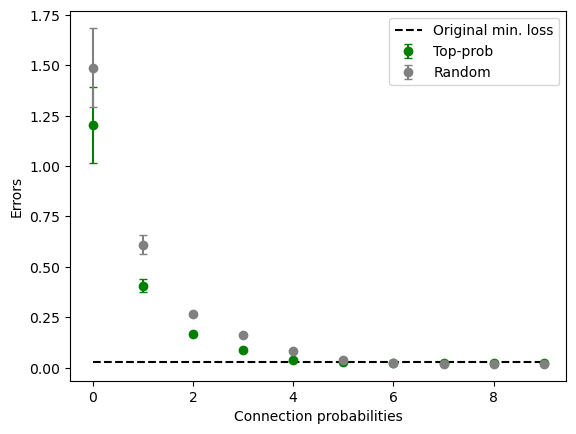

In [90]:
fig, ax = plt.subplots()

plt.errorbar(np.arange(n_fine), np.mean(train_losses_finetuned_topprob_np,0), yerr=np.var(train_losses_finetuned_topprob_np,0),
             fmt='o', capsize=3, color='g', label='Top-prob')
plt.errorbar(np.arange(n_fine), np.mean(train_losses_finetuned_random_np,0), yerr=np.var(train_losses_finetuned_random_np,0),
             fmt='o', capsize=3, color='grey', label='Random')
plt.plot(np.arange(n_fine),[avg_min]*n_fine,'--',color='k',label='Original min. loss')

plt.legend()
plt.ylabel('Errors')
plt.xlabel('Epochs retrained')
plt.title('0.9 Sparsity Losses with retraining: Wave recon')